<a href="https://colab.research.google.com/github/myke11j/kaggle-competetions/blob/master/LANL-Earthquake-Prediction/kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! pip install catboost
! pip install numpy

     |████████████████████████████████| 61.2MB 1.5MB/s 


# **Import libraries**

In [0]:
# for data processing and maths operation
import pandas as pd
import numpy as np

# for ML model
from catboost import CatBoostRegressor, Pool
from sklearn.svm import SVR, NuSVR

# for scaling
from sklearn.preprocessing import StandardScaler

# for hyper model tuning
from sklearn.model_selection import GridSearchCV

# for kernel grid
from sklearn.kernel_ridge import KernelRidge

# for visualisation
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error


In [3]:
print(pd.__version__)
print(np.__version__)

0.24.2
1.16.4


# **Import files**

In [4]:
from google.colab import files
uploaded = files.upload()

! mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/kaggle/

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/kaggle/': No such file or directory


In [5]:
# kaggle competeion list
! kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       3039           False  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11433            True  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4451            True  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         46           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       3612           False  
open-images-2019-object-detection                  2019-10-01 23:59:00  Research           $25,000      

In [6]:
# Download the dataset

! kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 62.1MB/s]
 96% 233M/242M [00:03<00:00, 65.2MB/s]
100% 242M/242M [00:03<00:00, 72.0MB/s]
100% 2.02G/2.03G [00:52<00:00, 33.3MB/s]
100% 2.03G/2.03G [00:52<00:00, 41.5MB/s]


In [8]:
# check if data is there mow
# !mkdir test
# !unzip test.zip -d test/
# !unzip train.csv.zip
!ls

sample_data  sample_submission.csv  test  test.zip  train.csv  train.csv.zip


# **Data Analysis**

In [17]:

#Extract training data into a dataframe for further manipulation
train = pd.read_csv('train.csv', nrows=200000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
print(train.shape)
train.head()

(200000, 2)


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [18]:
rows = 15
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

 
for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()

100%|██████████| 13333/13333 [00:19<00:00, 689.33it/s]


In [19]:
X_train.shape

(13333, 4)

In [20]:
y_train.shape

(13333, 1)

In [21]:
X_train.head(10)

,ave,std,max,min
0,4.800000,4.150502,12.0,-5.0
1,6.066667,2.815828,14.0,2.0
2,4.800000,2.688246,11.0,0.0
3,6.800000,3.208323,11.0,2.0
4,3.800000,3.124100,9.0,-4.0
5,6.200000,3.208323,13.0,-2.0
6,5.133333,4.193116,12.0,-1.0
7,5.266667,2.434931,10.0,1.0
8,4.733333,2.719477,8.0,-1.0
9,6.000000,3.386247,13.0,1.0


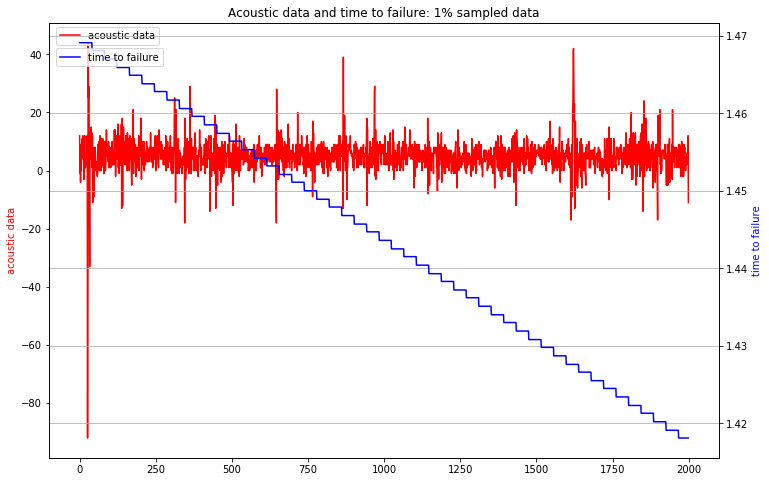

In [22]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

# Feature **Enginnering**

In [0]:
# Step 4 - Feature Engineering and signifiance of these statistical features

#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [16]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

KeyboardInterrupt: ignored

In [23]:
X_train.describe()

,ave,std,max,min
count,13333.000000,13333.000000,13333.000000,13333.000000
mean,4.837241,3.818307,11.307358,-1.639091
std,2.576561,3.411683,5.535978,5.503002
min,-85.933333,0.884433,-11.000000,-154.000000
25%,4.066667,2.412928,9.000000,-2.000000
50%,4.866667,2.958979,10.000000,0.000000
75%,5.600000,3.885014,12.000000,1.000000
max,107.533333,74.016815,181.000000,13.000000


In [24]:
train_pool = Pool(X_train, y_train)

# for interation in list([100, 5000, 10000, 20000]):
#   m = CatBoostRegressor(iterations=interation, loss_function='MAE', boosting_type='Ordered')
#   m.fit(X_train, y_train, silent=True)
#   print('Iteration {}, {}'.format(interation, m.best_score_))

m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
print('Iteration {}, {}'.format(10000, m.best_score_))

Iteration 10000, {'learn': {'MAE': 0.009307698756463378}}


In [0]:
y_pred = m.predict(X_train)

In [26]:
score = mean_absolute_error(y_train.values.flatten(), y_pred)
print(f'Score: {score:0.3f}')

Score: 0.009


In [0]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')


In [0]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)


In [0]:
for seg_id in X_test.index:
    seg = pd.read_csv('test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()

In [0]:
X_test.head(10)

,ave,std,max,min
seg_id,,,,
seg_00030f,4.491780,4.893673,115.0,-75.0
seg_0012b5,4.171153,5.922820,152.0,-140.0
seg_00184e,4.610260,6.946967,248.0,-193.0
seg_003339,4.531473,4.114133,85.0,-93.0
seg_0042cc,4.128340,5.797144,177.0,-147.0
seg_004314,4.148607,24.782686,671.0,-675.0
seg_004cd2,4.113987,4.707134,125.0,-107.0
seg_004ee5,4.328380,5.964423,120.0,-120.0
seg_004f1f,4.000733,5.874450,118.0,-114.0


In [0]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = m.predict(X_test_scaled)
submission.to_csv('submission.csv')

In [0]:
m.predict(X_test_scaled)

array([1.18539319, 1.0635061 , 0.62736309, ..., 0.45962658, 0.8824993 ,
       1.23160584])

In [0]:
submissionDf = pd.read_csv('submission.csv')

In [0]:
submissionDf.head()

,seg_id,time_to_failure
0,seg_00030f,1.185393
1,seg_0012b5,1.063506
2,seg_00184e,0.627363
3,seg_003339,1.233687
4,seg_0042cc,0.927337


# **Submit result to Kaggle**

In [0]:
!kaggle competitions submit -c LANL-Earthquake-Prediction -f submission.csv -m "First submission using catboost"

100% 76.5k/76.5k [00:02<00:00, 33.7kB/s]
Successfully submitted to LANL Earthquake Prediction